---
**Report for EMAT30008**

Author: Ben Winstanley, yy23737@bristol.ac.uk

---

***Software Demo***

In [1]:
# Import our library and other packages needed for the demo
import numpy as np
import matplotlib.pyplot as plt
from scicomp.odefunctions import *
import timeit

/Applications/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"



*1)*   We consider the Brusselator system:

$\frac{dx}{dt} = A + x^2 y - (B + 1)x$

$\frac{dy}{dt} = B x - x^2 y$

which undergoes a supercritical Hopf bifurcation for $B=1+A^2$. We fix $A=1$ (so our bifurcation occurs at $B=2$).

*(a)* We fix $B=3$ and calculate the solution for $0\leq t \leq 20$, starting from initial state $(1,1)$. We use the Euler timestepping method with a step size of $0.01$, and we plot both variables over time on a single figure.

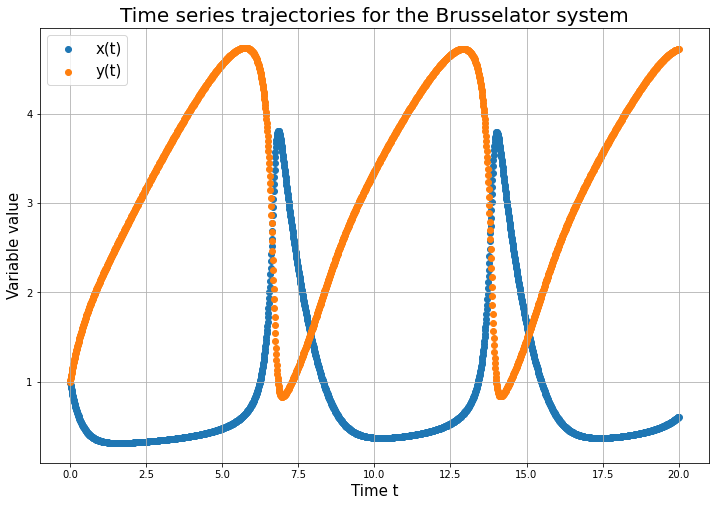

In [2]:
# First define the system ODE as a function
def brusselator(params: list[float], x:np.ndarray, t:float):
    ''' RHS of the Brusselator ODE.'''

    # Unpack parameters and variables
    A,B = params
    x,y = x[0], x[1]

    # Calculate each expression
    dxdt = A + (x**2)*y - (B+1)*x
    dydt = B*x - (x**2)*y
    return np.array(([dxdt, dydt]))

# Call the solve_to function, using the Euler method with a step size of 0.01
params = [1,3]
x_init = np.array(([1,1]))
t_init, t_final = 0, 20
deltat_max = 0.01
method = 'Euler'
store = solve_to(brusselator, params, x_init, t_init, t_final, deltat_max, method)

# Plot the x and y solutions versus time
tvals = store[:,0]
xvals, yvals = store[:,1], store[:,2]
plt.figure(figsize=[12,8])
plt.scatter(tvals,xvals, label='x(t)')
plt.scatter(tvals, yvals, label='y(t)')
plt.grid()
plt.legend(fontsize=15)
plt.xlabel("Time t", fontsize=15)
plt.ylabel("Variable value", fontsize=15)
plt.title("Time series trajectories for the Brusselator system", fontsize=20)
plt.show()


*(b)* We use numerical shooting to identify the coordinates of a starting point along the limit cycle seen above, along with its period. We use a derivative phase condition. From the plot above we use $7.5$ as an estimate for the period, and $(1.5,1.5)$ as an intial condition.

In [3]:
init_period_guess = 7.5
init_point_guess = [1.5,1.5]
# Call the find_limit_cycle function with these guesses
period, init_point = find_limit_cycle(brusselator,params, init_point_guess, init_period_guess,
                                      1,'derivative')

A limit cycle was found:
Period: 7.16 ,
Starting state: [0.37 3.51] .


*(c)* We use natural-parameter continuation to find the branch of limit cycles emerging from the Hopf bifurcation at $B=2$. We take steps backwards from our discovered limit cycle at $B=3$.

In [4]:
vary_param_index = 1
vary_param_start = 3
vary_param_step = -0.05
init_period_guess = period
init_point_guess = np.array(([1.5,1.56]))
num_steps = 20
method = 'NPC'
phase_condition = 'constant'
constant_value = 1

# Call the limit_cycle_continuation function to vary B in steps of 0.01 from 2 to 3.
# We use natural-parameter continuation with 100 steps, and for each limit cycle
# we search with a derivative phase condition
pair_store, B_store = limit_cycle_continuation(brusselator, params,
                                                vary_param_index, vary_param_start,
                                                vary_param_step,init_point_guess,
                                                init_period_guess, num_steps,
                                                method, 1, phase_condition, constant_value)

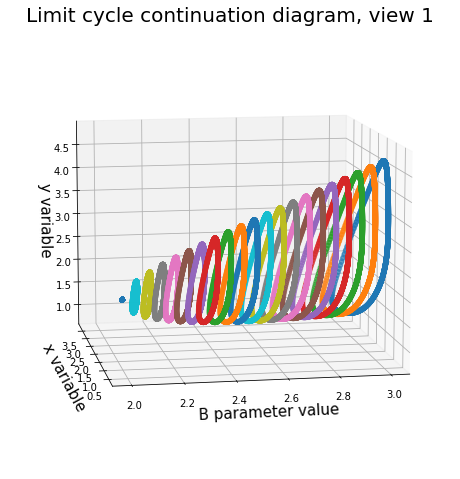

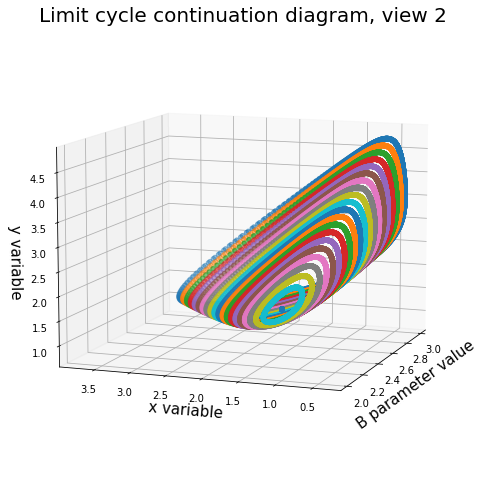

In [5]:
# We plot our findings on a pair of 3D plots
fig = plt.figure(figsize = (8,12))
ax = plt.axes(projection='3d')
for index, B in enumerate(B_store):
    params[vary_param_index]=B
    period, init_point, = pair_store[index,0], pair_store[index,1:]
    store = solve_to(brusselator,params,init_point,0,2*period,0.01)
    yvals, zvals = store[:,1], store[:,2]
    xvals = B*np.ones([len(yvals)])
    ax.scatter(xvals,yvals,zvals, zorder=10*index)
ax.view_init(10,260)
plt.title("Limit cycle continuation diagram, view 1",pad=-20 ,fontsize=20)
ax.set_xlabel("B parameter value",fontsize=15)
ax.set_ylabel("x variable",fontsize=15)
ax.set_zlabel("y variable",fontsize=15)
plt.show()

fig = plt.figure(figsize = (8,12))
ax = plt.axes(projection='3d')
for index, B in enumerate(B_store):
    params[vary_param_index]=B
    period, init_point, = pair_store[index,0], pair_store[index,1:]
    store = solve_to(brusselator,params,init_point,0,2*period,0.01)
    yvals, zvals = store[:,1], store[:,2]
    xvals = B*np.ones([len(yvals)])
    ax.scatter(xvals,yvals,zvals, zorder=10*index)
ax.view_init(10,200)
plt.title("Limit cycle continuation diagram, view 2",pad=-20 ,fontsize=20)
ax.set_xlabel("B parameter value",fontsize=15)
ax.set_ylabel("x variable",fontsize=15)
ax.set_zlabel("y variable",fontsize=15)
plt.show()

---------

*2)* We consider the extended Hopf bifurcation normal form system:

$\frac{dx}{dt} = \beta x - y - z + x(x^2 + y^2 + z^2) - x(x^2 + y^2 + z^2)^2$

$\frac{dy}{dt} = x + \beta y - z + y(x^2 + y^2 + z^2) - y(x^2 + y^2 + z^2)^2$

$\frac{dz}{dt} = x + y + \beta z + z(x^2 + y^2 + z^2) - z(x^2 + y^2 + z^2)^2$,

which undergoes a subcritical Hopf bifurcation at $\beta = 0$.

*(a)* We fix $\beta=1$ and calculate the solution for $0\leq t \leq 10$, starting from initial state $(1,0,-1)$. We use the 4th-order Runge-Kutta timestepping method with a step size of $0.01$, and we plot both variables over time on a single figure.

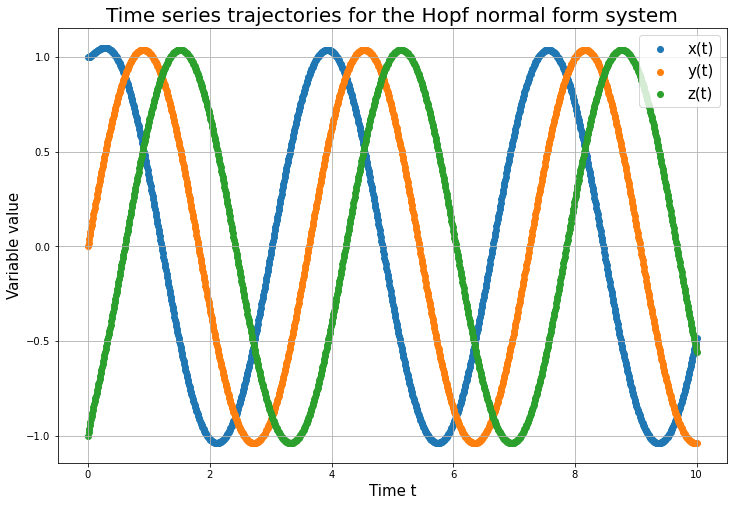

In [6]:
# First define the system ODE as a function
def extended_hopf(params,x,t):
    ''' RHS of the extended Hopf bifurcation normal form ODE.'''
    
    # Unpack parameters and variables
    beta = params[0]
    x, y, z = x[0], x[1], x[2]

    dxdt = beta * x - y - z + x * (x**2 + y**2 + z**2) - x * (x**2 + y**2 + z**2)**2
    dydt = x + beta * y - z + y * (x**2 + y**2 + z**2) - y * (x**2 + y**2 + z**2)**2
    dzdt = x + y + beta * z + z * (x**2 + y**2 + z**2) - z * (x**2 + y**2 + z**2)**2
    return np.array(([dxdt, dydt, dzdt]))

# Call the solve_to function, using the RK4 method with a step size of 0.01
params = [1]
x_init = np.array(([1,0,-1]))
t_init, t_final = 0, 10
deltat_max = 0.01
method = 'RK4'
store = solve_to(extended_hopf, params, x_init, t_init, t_final, deltat_max, method)

# Plot the x and y solutions versus time
tvals = store[:,0]
xvals, yvals, zvals = store[:,1], store[:,2], store[:,3]
plt.figure(figsize=[12,8])
plt.scatter(tvals,xvals, label='x(t)')
plt.scatter(tvals, yvals, label='y(t)')
plt.scatter(tvals, zvals, label='z(t)')
plt.grid()
plt.legend(fontsize=15)
plt.xlabel("Time t", fontsize=15)
plt.ylabel("Variable value", fontsize=15)
plt.title("Time series trajectories for the Hopf normal form system", fontsize=20)
plt.show()


*(b)* We use numerical shooting to identify the coordinates of a starting point along the limit cycle seen above, along with its period. We use a constant phase condition. From the plot above we use $4$ as an estimate for the period, $(1,0.6,-0.4)$ as an intial condition, and $1$ as a constant value.

In [7]:
init_period_guess = 4
init_point_guess = [1,0.6,-0.4]
phase_condition = 'constant'
constant_value = 1
# Call the find_limit_cycle function with these guesses
period, init_point = find_limit_cycle(extended_hopf,params, init_point_guess, init_period_guess,
                                      1, phase_condition,constant_value)

A limit cycle was found:
Period: 3.63 ,
Starting state: [ 1.    0.74 -0.26] .


*(c)* We use pseudo-arclength continuation to find the branch of limit cycles emerging from the Hopf bifurcation at $\beta=0$. We take steps backwards from our discovered limit cycle at $B=1$.

In [8]:
vary_param_index = 0
vary_param_start = 1
vary_param_step = -0.005
init_period_guess = period
init_point_guess = init_point
num_steps = 100
method = 'PAC'
phase_condition = 'constant'
constant_value = 1

# Call the limit_cycle_continuation function to vary B in steps of 0.01 from 2 to 3.
# We use natural-parameter continuation with 100 steps, and for each limit cycle
# we search with a derivative phase condition
pair_store, beta_store = limit_cycle_continuation(extended_hopf, params,
                                                vary_param_index, vary_param_start,
                                                vary_param_step,init_point_guess,
                                                init_period_guess, num_steps,
                                                method, 1, phase_condition, constant_value)

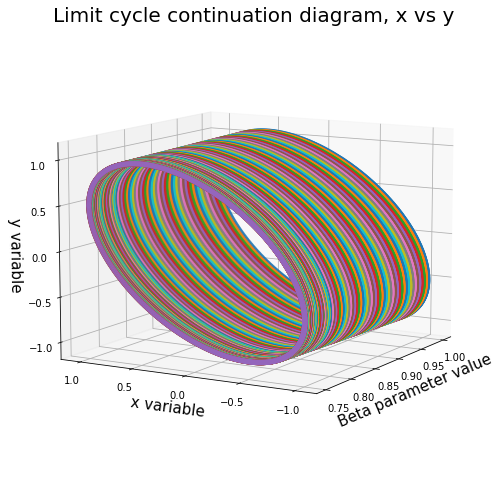

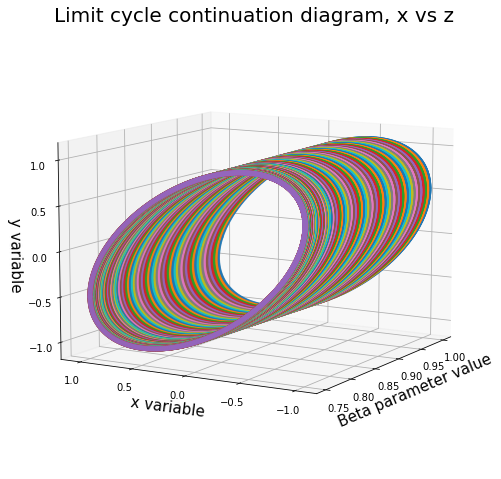

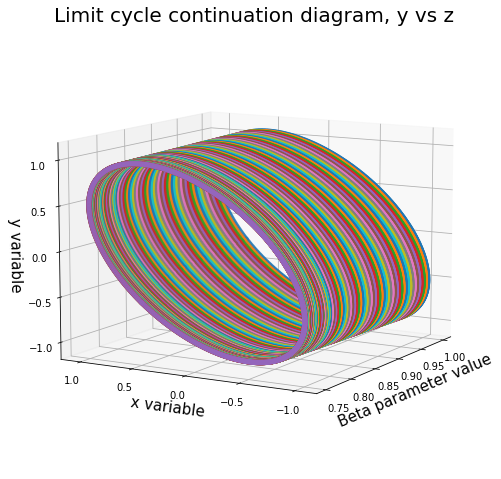

In [9]:
# We plot our findings on 3 3D plots, showing the relations between pairs of variables
fig = plt.figure(figsize = (8,12))
ax = plt.axes(projection='3d')
for index, beta in enumerate(beta_store):
    params[vary_param_index]=beta
    period, init_point, = pair_store[index,0], pair_store[index,1:]
    store = solve_to(extended_hopf,params,init_point,0,2*period,0.01)
    yvals, zvals = store[:,1], store[:,2]
    xvals = beta*np.ones([len(yvals)])
    ax.scatter(xvals,yvals,zvals, zorder=10*index)
ax.view_init(10,210)
plt.title("Limit cycle continuation diagram, x vs y",pad=-20 ,fontsize=20)
ax.set_xlabel("Beta parameter value",fontsize=15)
ax.set_ylabel("x variable",fontsize=15)
ax.set_zlabel("y variable",fontsize=15)
plt.show()

fig = plt.figure(figsize = (8,12))
ax = plt.axes(projection='3d')
for index, beta in enumerate(beta_store):
    params[vary_param_index]=beta
    period, init_point, = pair_store[index,0], pair_store[index,1:]
    store = solve_to(extended_hopf,params,init_point,0,2*period,0.01)
    yvals, zvals = store[:,1], store[:,3]
    xvals = beta*np.ones([len(yvals)])
    ax.scatter(xvals,yvals,zvals, zorder=10*index)
ax.view_init(10,210)
plt.title("Limit cycle continuation diagram, x vs z",pad=-20 ,fontsize=20)
ax.set_xlabel("Beta parameter value",fontsize=15)
ax.set_ylabel("x variable",fontsize=15)
ax.set_zlabel("y variable",fontsize=15)
plt.show()

fig = plt.figure(figsize = (8,12))
ax = plt.axes(projection='3d')
for index, beta in enumerate(beta_store):
    params[vary_param_index]=beta
    period, init_point, = pair_store[index,0], pair_store[index,1:]
    store = solve_to(extended_hopf,params,init_point,0,2*period,0.01)
    yvals, zvals = store[:,2], store[:,3]
    xvals = beta*np.ones([len(yvals)])
    ax.scatter(xvals,yvals,zvals, zorder=10*index)
ax.view_init(10,210)
plt.title("Limit cycle continuation diagram, y vs z",pad=-20 ,fontsize=20)
ax.set_xlabel("Beta parameter value",fontsize=15)
ax.set_ylabel("x variable",fontsize=15)
ax.set_zlabel("y variable",fontsize=15)
plt.show()

---------

*3)* We consider the Poisson equation given by:

$ D\frac{d^2 u}{d x^2} + \frac{1}{\sqrt{2 \pi \sigma^2 }} e^{\frac{-x^2}{ 2 \sigma^2 }}$ = 0

where $\sigma > 0$ is a parameter, and $-1 \leq x \leq 1$, with boundary conditions $u(-1)=u(1)=-1$, and diffusivity constant $D=1$.

*(a)(i)* We set $\sigma = 0.5$ and solve this poisson equation by method of finite differences. Since the gaussian source term is only dependent on $x$, our method automatically uses Numpy's linalg package to solve.

u(0) =  -0.6958 .


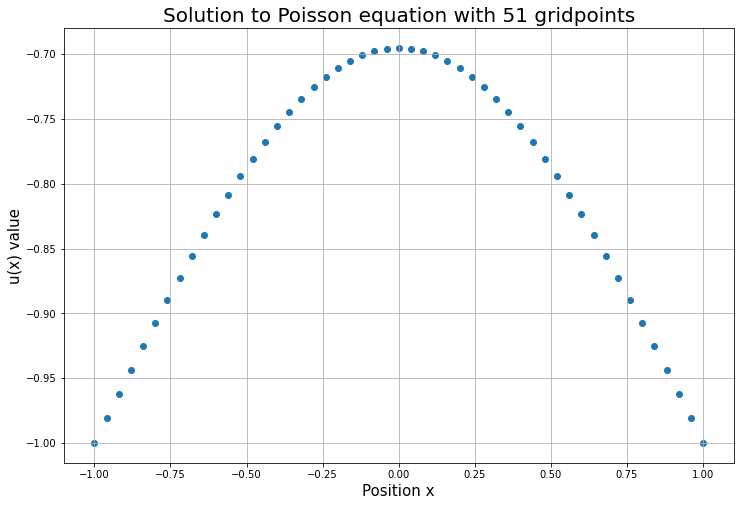

In [10]:
# We first construct the matrix A and vector b which encapsulate 
# the diffusion term and dirichlet boundary conditions on each side
num_grid_points = 51
grid_bounds = [-1,1]
left_boundary_vals, right_boundary_vals = [-1], [-1]
left_boundary_type, right_boundary_type = 'Dirichlet', 'Dirichlet'
A_matrix, b_vec, left_dirichlet_val, right_dirichlet_val = bvp_construct_A_and_b(num_grid_points,
                                                                            grid_bounds,
                                                                            left_boundary_vals,
                                                                            right_boundary_vals,
                                                                            left_boundary_type,
                                                                            right_boundary_type)

# We then specify a function q to encode the source term
def gaussian(x,u,mu):
    '''Function to encode the source term in our Poisson equation'''
    constant = 1/(np.sqrt(2*np.pi*(mu**2)))
    exp_term = np.exp((-(x)**2)/(2*(mu)**2))
    return constant*exp_term

# We pass these pieces of information into our main solver function
diffusivity = 1
sigma = 0.5
solution, xvals = finite_diff_bvp_solver(num_grid_points, diffusivity, grid_bounds,
                                         A_matrix, b_vec, left_dirichlet_val,right_dirichlet_val,
                                         gaussian,False,sigma)

# We print the value of u(0)
u0solution = solution[int((num_grid_points+1)/2)]
print("u(0) = ", round(u0solution,4),".")

# We then plot the solution
plt.figure(figsize=[12,8])
plt.scatter(xvals, solution)
plt.grid()
plt.xlabel("Position x", fontsize=15)
plt.ylabel("u(x) value", fontsize=15)
plt.title("Solution to Poisson equation with 51 gridpoints", fontsize=20)
plt.show()


*(b)(i)* We increase the number of grid points used, and time our code's performance

u(0) =  -0.6952 .


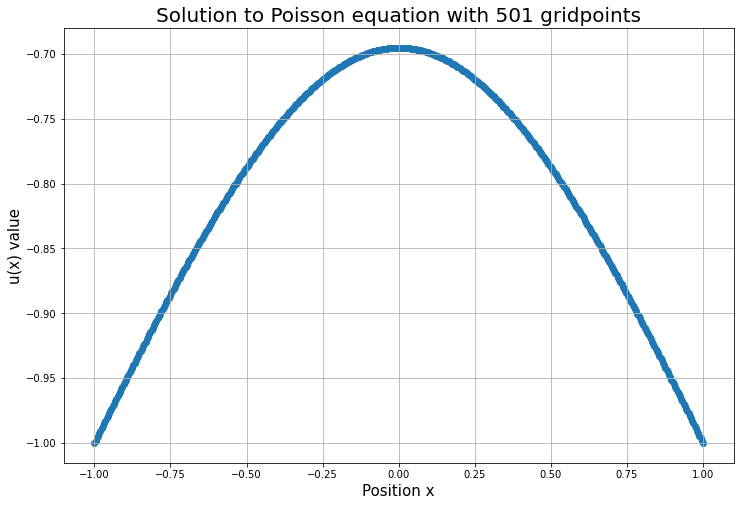

In [11]:
# Update the number of gridpoints
num_grid_points = 501

# Reconstruct our matrix and vector
A_matrix, b_vec, left_dirichlet_val, right_dirichlet_val = bvp_construct_A_and_b(num_grid_points,
                                                                            grid_bounds,
                                                                            left_boundary_vals,
                                                                            right_boundary_vals,
                                                                            left_boundary_type,
                                                                            right_boundary_type)

# Solve the ODE again
solution, xvals = finite_diff_bvp_solver(num_grid_points, diffusivity, grid_bounds,
                                         A_matrix, b_vec, left_dirichlet_val,right_dirichlet_val,
                                         gaussian,False,sigma)

# We print the value of u(0)
u0solution = solution[int((num_grid_points+1)/2)]
print("u(0) = ", round(u0solution,4),".")

# We then plot the solution
plt.figure(figsize=[12,8])
plt.scatter(xvals, solution)
plt.grid()
plt.xlabel("Position x", fontsize=15)
plt.ylabel("u(x) value", fontsize=15)
plt.title("Solution to Poisson equation with 501 gridpoints", fontsize=20)
plt.show()

In [12]:
# We now time our code:
setup_code = '''
import numpy as np
from scicomp.odefunctions import bvp_construct_A_and_b, finite_diff_bvp_solver

num_grid_points = 501
grid_bounds = [-1,1]
left_boundary_vals, right_boundary_vals = [-1], [-1]
left_boundary_type, right_boundary_type = 'Dirichlet', 'Dirichlet'

def gaussian(x,u,mu):
    constant = 1/(np.sqrt(2*np.pi*(mu**2)))
    exp_term = np.exp((-(x)**2)/(2*(mu)**2))
    return constant*exp_term

diffusivity = 1
sigma = 0.5
'''

timed_code = '''
A_matrix, b_vec, left_dirichlet_val, right_dirichlet_val = bvp_construct_A_and_b(num_grid_points,
                                                                            grid_bounds,
                                                                            left_boundary_vals,
                                                                            right_boundary_vals,
                                                                            left_boundary_type,
                                                                            right_boundary_type)
solution, xvals = finite_diff_bvp_solver(num_grid_points, diffusivity, grid_bounds,
                                         A_matrix, b_vec, left_dirichlet_val,right_dirichlet_val,
                                         gaussian,False,sigma)
'''

num_repeats = 1000
total_time = timeit.timeit(stmt=timed_code, setup=setup_code, number=num_repeats)
print("Total run time is:", round(total_time,2),
       "seconds. \nTime per trial: ", round(total_time/num_repeats,4), "seconds.")

Total run time is: 18.04 seconds. 
Time per trial:  0.018 seconds.


A sparse linear algebra approach is not implemented, but if it were, we would expect it to greatly outperform the dense linear algebra approach. This is because our dense linear algebra approach involves performing matrix operations with very sparse tri-diagonal matrices which contain mostly zeros. The number of operations is greatly reduced when using sparse algebra methods which would only involve the non-zero entries.

-------------

*4)* We consider the diffusion equation:

$\frac{dx}{dt} = D \frac{d^2 u}{d x^2} $

with $0 \leq x \leq L$, $\ 0 \leq t \leq T$. 

The boundary conditions are $\left. \frac{du}{dx} \right|_{x=0} = 1, u(L,t) = 0$, and the initial condition is $u(x,0) = \frac{1}{2}x(L-x)$.

We use $D=0.5, L=2, T=0.5$, with $101$ grid points.

*(a)* The maximum value of timestep we can use before the explicit euler method becomes unstable
is given by the following formula: 

$C = \frac{\Delta t D}{(\Delta x)^2} \leq \frac{1}{2}$, and so $\Delta t_{max} = \frac{(\Delta x)^2}{2 D}.$

In [21]:
# Set out information given
L = 2
D = 0.5
T = 10
num_grid_points = 101
grid_bounds = [0,L]

def init_func(x):
    ''' Initial condition function u(x,0).'''
    return 0.5*x*(L-x)

# Calculate delta_x
delta_x = L/(num_grid_points-1)

# Calculate delta_t_max
delta_t_max = (delta_x**2)/(2*D)

print("delta_t_max = ", round(delta_t_max,4))

delta_t_max =  0.0004


*(b)(i)* We solve the equation with the explicit Euler timestepping method for timestep $0.5 \Delta t_{max}$

In [22]:
store, xvals = diffusion_pde_solver(num_grid_points,grid_bounds,D,init_func,0,T,
                                    0.5*delta_t_max, [1], [0], 'Neumann', 'Dirichlet')

u(0,T) = -1.9055


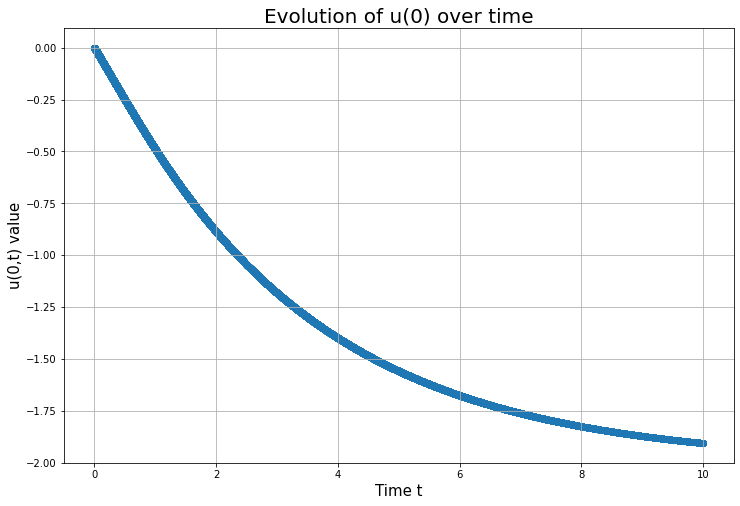

In [23]:
# We print the value u(0,T)
u0T = store[-1,1]
print("u(0,T) =", round(u0T,4))

# We plot u(0,t)
plt.figure(figsize=[12,8])
plt.scatter(store[:,0],store[:,1])
plt.grid()
plt.xlabel("Time t", fontsize=15)
plt.ylabel("u(0,t) value", fontsize=15)
plt.title("Evolution of u(0) over time", fontsize=20)
plt.show()

-----------

**Design Decisions**

We now review the design decisions made throughout this project, in roughly chronological order.
